In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import learning_curve
def cross_validate_learning_rate(estimator, x_train, y_train, cv = 5, scoring = 'roc_auc', return_train_score = True):
    results = cross_validate(estimator,
                            x_train,
                            y_train,
                            cv = cv,
                            scoring=scoring,
                            return_train_score = return_train_score ) 
    train_scores = results['train_score']
    test_scores = results['test_score']
    print("train_scores: {}".format(np.mean(train_scores)))
    print("test_scores: {}".format(np.mean(test_scores)))

    lc = learning_curve(estimator, 
                        x_train, 
                        y_train, 
                        cv=cv, 
                        scoring=scoring)
    samples, train, test = lc[0],lc[1],lc[2]
    plt.plot(samples, np.mean(train, axis=1))
    plt.plot(samples, np.mean(test, axis=1))

In [3]:
from sklearn.model_selection import GridSearchCV
def grid_search_param(X, y,nfolds, param_grid, model_sklearn, scoring = 'roc_auc'):
    grid_search = GridSearchCV(model_sklearn, param_grid, cv=nfolds, return_train_score=True, scoring=scoring)
    grid_search.fit(X, y)
    return grid_search

In [4]:
path = '../data'
y_train = pd.read_csv(f'{path}/y_train.csv', index_col = 'key_value')

In [5]:
list_train_probs = []
list_train_probs.append(pd.read_pickle('train_probs_lightgbm.pkl'))
list_train_probs.append(pd.read_pickle('train_probs_catboost.pkl'))
list_train_probs.append(pd.read_pickle('train_probs_xgb.pkl'))
list_train_probs.append(pd.read_pickle('train_probs_gbc.pkl'))
list_train_probs.append(pd.read_pickle('train_probs_lightgbm_v2.pkl'))
train = pd.concat(list_train_probs, axis=1)
train.columns = ['probs_lightgbm', 'probs_catboost','probs_xgb', 'probs_gbc', 'probs_lightgbm_v2']

In [6]:
list_test_probs = []
list_test_probs.append(pd.read_pickle('test_probs_lightgbm.pkl'))
list_test_probs.append(pd.read_pickle('test_probs_catboost.pkl'))
list_test_probs.append(pd.read_pickle('test_probs_xgb.pkl'))
list_test_probs.append(pd.read_pickle('test_probs_gbc.pkl'))
list_test_probs.append(pd.read_pickle('test_probs_lightgbm_v2.pkl'))
test = pd.concat(list_test_probs, axis=1)
test.columns  = ['probs_lightgbm', 'probs_catboost', 'probs_xgb', 'probs_gbc', 'probs_lightgbm_v2']

In [7]:
keep_columns = ['probs_lightgbm', 'probs_lightgbm_v2','probs_catboost','probs_xgb'] 
train = train[keep_columns]
test = test[keep_columns]

In [8]:
train.corr()

,probs_lightgbm,probs_lightgbm_v2,probs_catboost,probs_xgb
probs_lightgbm,1.000000,0.983628,0.981097,0.975524
probs_lightgbm_v2,0.983628,1.000000,0.976367,0.969840
probs_catboost,0.981097,0.976367,1.000000,0.974262
probs_xgb,0.975524,0.969840,0.974262,1.000000


In [9]:
test.corr()

,probs_lightgbm,probs_lightgbm_v2,probs_catboost,probs_xgb
probs_lightgbm,1.000000,0.992589,0.990563,0.992066
probs_lightgbm_v2,0.992589,1.000000,0.987350,0.987958
probs_catboost,0.990563,0.987350,1.000000,0.991087
probs_xgb,0.992066,0.987958,0.991087,1.000000


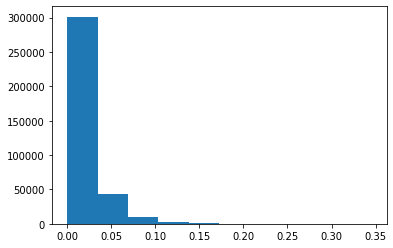

In [10]:
plt.hist(np.std(train.values, axis=1));

### Entrenando el modelo final

In [20]:
from sklearn.linear_model import LogisticRegression
### definir los parametros a tunear
Cs = [0.1, 0.3, 0.8, 0.9, 1.0]
# https://neurtu.readthedocs.io/examples/logistic_regression_scaling.html
solvers = ['lbfgs','saga','newton-cg'] # newton-cg, sag, lbfgs, liblinear, saga
param_grid = {'C': Cs,'solver':solvers}
### encontrando los hiper_parámetros
fitting=grid_search_param(train, y_train.target, 5,param_grid, LogisticRegression(penalty="l2", tol=0.0001, random_state=42), scoring='roc_auc')
### instanciar el estimador
estimator = fitting.best_estimator_
print(estimator)
### aplicar cross_validate y learning_rate 
# cross_validate_learning_rate(estimator, train, y_train, scoring='roc_auc')

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


train_scores: 0.8546741550431814
test_scores: 0.8546459877274858


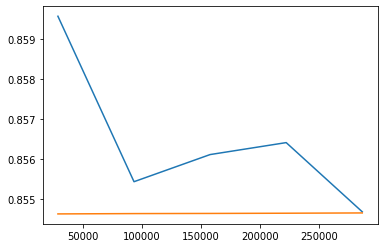

In [21]:
### aplicar cross_validate y learning_rate 
cross_validate_learning_rate(estimator, train, y_train.target, scoring='roc_auc')

In [25]:
test_stacking = pd.Series(estimator.predict_proba(test)[:,-1], index=test.index, name = 'target')
test_stacking

key_value
0         0.044932
1         0.066908
2         0.053932
3         0.605238
4         0.117123
            ...   
396661    0.066878
396662    0.146606
396663    0.195737
396664    0.056225
396665    0.059478
Name: target, Length: 396666, dtype: float64

In [15]:
######################
# ['probs_lightgbm', 'probs_catboost']
# train_scores: 0.8542015438696666
# test_scores: 0.8541920536095156
######################
# ['probs_lightgbm', 'probs_xgb']
# train_scores: 0.8537336303022318
# test_scores: 0.8537153296347725
######################
# ['probs_lightgbm', 'probs_gbc']
# train_scores: 0.8533152324085977
# test_scores: 0.8532880990430135
######################
# ['probs_lightgbm', 'probs_lightgbm_v2']  ******
# train_scores: 0.8542166969058126
# test_scores: 0.8542013048045209
######################
# ['probs_lightgbm', 'probs_catboost', 'probs_xgb']
# train_scores: 0.8542750396538642
# test_scores: 0.8542564156239385
######################
# ['probs_lightgbm', 'probs_catboost', 'probs_gbc']
# train_scores: 0.8541521971557591
# test_scores: 0.854124194608111
######################
# ['probs_lightgbm', 'probs_lightgbm_v2','probs_catboost']  ****** Probar con esto para mañana
# train_scores: 0.8546467151913222
# test_scores: 0.8546258916989796
######################
# ['probs_lightgbm', 'probs_lightgbm_v2','probs_xgb']
# train_scores: 0.8543761504099889
# test_scores: 0.8543531308511978
######################
# ['probs_lightgbm', 'probs_lightgbm_v2','probs_gbc]
# train_scores: 0.8541762829377056
# test_scores: 0.8541427401970043
######################
# ['probs_lightgbm', 'probs_lightgbm_v2','probs_catboost','probs_xgb'] *****
# train_scores: 0.8546741550431814
# test_scores: 0.8546459877274858
######################
# ['probs_lightgbm', 'probs_catboost', 'probs_xgb', 'probs_gbc']
# train_scores: 0.8542370056429046
# test_scores: 0.8542013506721494
######################
# ['probs_lightgbm', 'probs_lightgbm', 'probs_catboost', 'probs_xgb', 'probs_gbc']
# train_scores: 0.8546605073604997
# test_scores: 0.8546139114491276

In [26]:
estimator.coef_

array([[2.67176899, 1.48894309, 1.84195922, 0.70294935]])

In [28]:
test_stacking.to_csv("../results/stacking_4models_LGBM2_CB_XGB_0.85464.csv")  ### score de 0.85596 en la tabla publica
# test_stacking.to_csv("../results/stacking_2models_LGBM_CB_0.85419.csv")  ### score de 0.85567 en la tabla publica

In [18]:
# test_stacking.to_csv("../results/stacking_3models_LGBM2_GBC_0.84805.csv")  ### score de 0.84996 en la tabla publica
# test_stacking.to_csv("../results/stacking_3models_LGBM2_R_0.84729.csv")  ### score de 0.84927 en la tabla publica
# test_stacking.to_csv("../results/stacking_6models_0.84767.csv")  ### score de 0.84910 en la tabla publica
# test_stacking.to_csv("../results/stacking_3models_LGBM2_RNN_0.84830.csv")  ### score de 0.84974 en la tabla publica
# test_stacking.to_csv("../results/stacking_3models_LGBM2_RF_0.84694.csv")  ### score de 0.84874  en la tabla publica
# test_stacking.to_csv("../results/stacking_3models_LGBM2_XGB_0.84807.csv")  ### score de 0.84977  en la tabla publica
# test_stacking.to_csv("../results/stacking_3models_LGBM2_0.84811.csv")  ### score de 0.84970  en la tabla publica
# test_stacking.to_csv("../results/stacking_2models_LGBM2_0.84801.csv")  ### score de 0.84992 en la tabla publica
# test_stacking.to_csv("../results/stacking_3models_CB_LGBM2_0.84834.csv")  ### score de 0.84991 en la tabla publica
# test_stacking.to_csv("../results/stacking_3models_CB_LGBM2_0.84833.csv") ### score de 0.84992 en la tabla publica
# test_stacking.to_csv("../results/stacking_2models_CB_LGBM_0.84721.csv") ### score de 0.84882 en la tabla publica

In [19]:
### Por lo que se puede concluir que los dos modelos de lightGBM (el normal, y el que toma en cuenta las categoricas).
### Tienen mejor performance